In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

2025-11-23 14:50:37.232424: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763909437.420837      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763909437.469272      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
BASE_DIR = "/kaggle/input/flickr30k"
WORKING_DIR = "/kaggle/working" 

In [4]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

I0000 00:00:1763909483.386710      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763909483.387513      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [7]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images/flickr30k_images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature

  0%|          | 0/31783 [00:00<?, ?it/s]

In [8]:
# Stores features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [9]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [10]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [12]:
# captions_doc

In [31]:
# create mapping of image to captions
mapping = {}
#process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

100%|██████████| 158916/158916 [00:00<00:00, 401807.76it/s]


In [32]:
len(mapping)

31783

In [33]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [34]:
# before preprocess of text
mapping['1000092795']

[' Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 '" Two young   White males are outside near many bushes ."',
 ' Two men in green shirts are standing in a yard .',
 ' A man in a blue shirt standing in a garden .',
 ' Two friends enjoy time spent together .']

In [35]:
# preprocess the text
clean(mapping)

In [36]:
# before preprocess of text
mapping['1000092795']

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes ." endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

In [37]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [38]:
len(all_captions)

158915

In [39]:
all_captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes ." endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [40]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [41]:
vocab_size

18314

In [42]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

75

In [43]:
import pickle

save_dict = {
    "max_length": max_length,
    "vocab_size": vocab_size,
    "tokenizer": tokenizer
}

with open("caption_config.pkl", "wb") as f:
    pickle.dump(save_dict, f)

In [44]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
# startseq A black dog leaps over a log endseq
#       X                        Y
# startseq                       a    
# startseq a                     black 
# startseq a black               dog
# ......................
# startseq A black dog leaps over a log       endseq

In [45]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                # yield [X1, X2], y
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

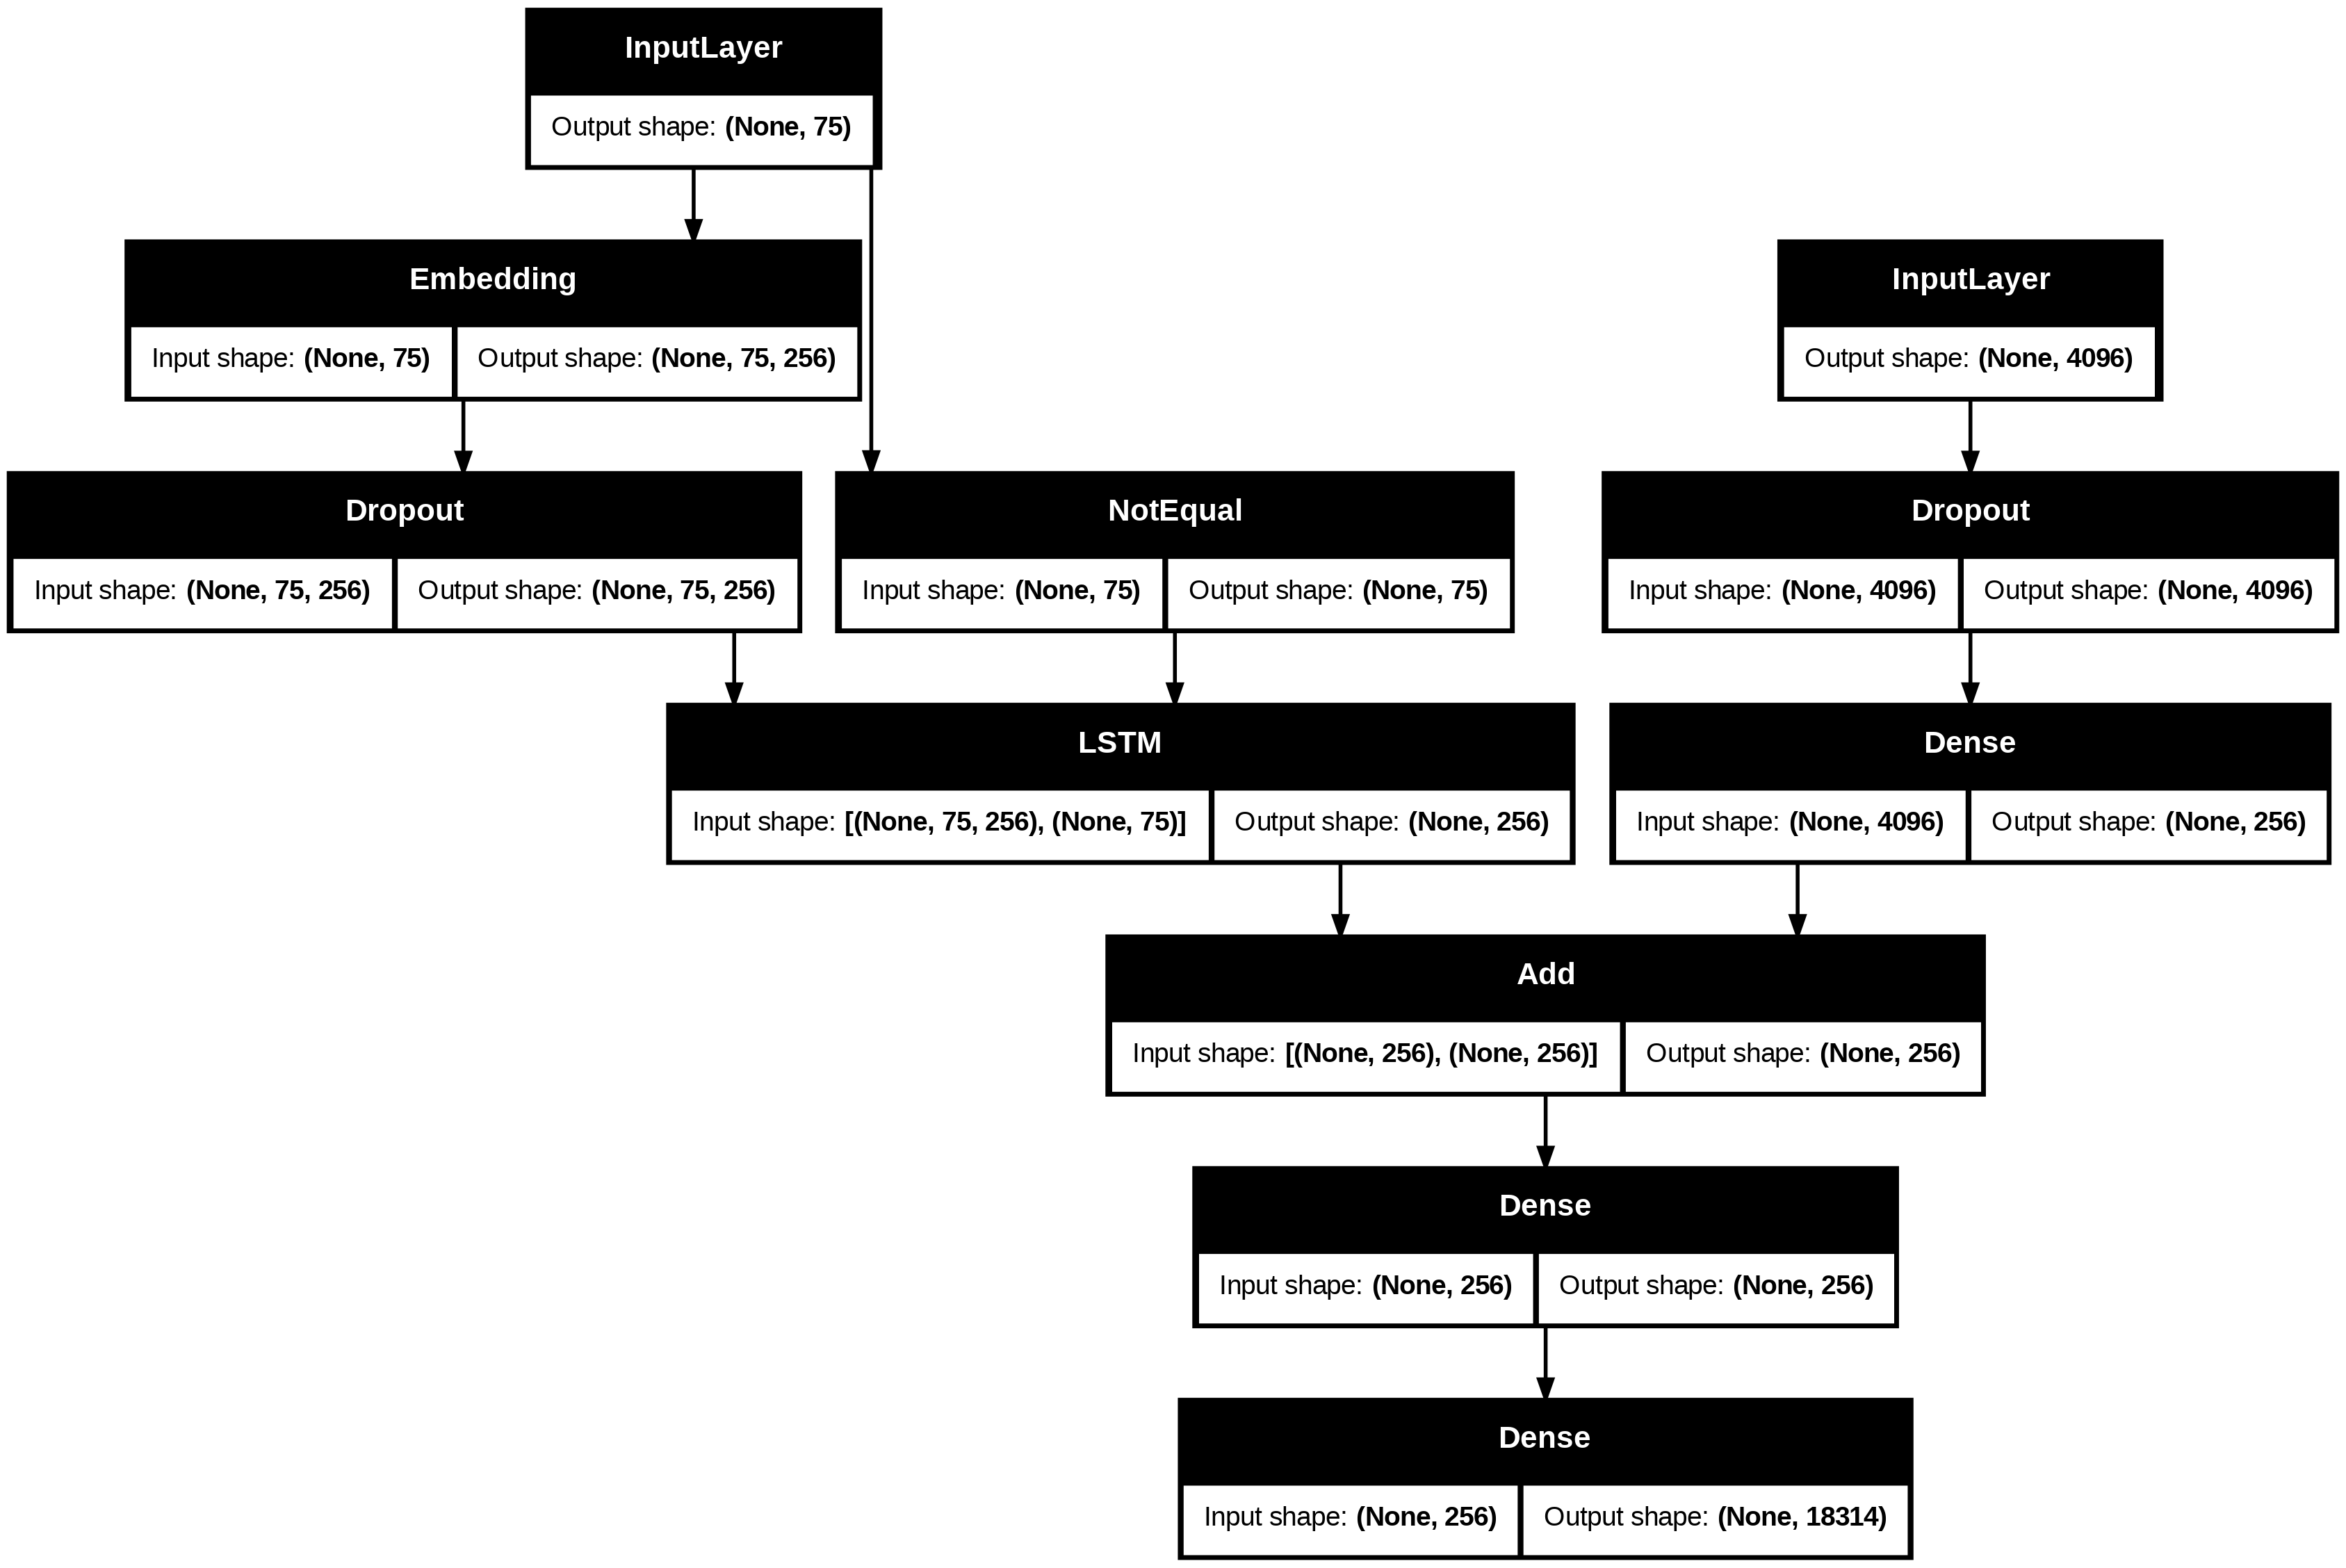

In [46]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
# se3 = LSTM(256)(se2)
se3 = LSTM(256, use_cudnn=False)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [47]:
import tensorflow as tf

epochs = 25
batch_size = 32
steps = len(train) // batch_size

def tf_generator():
    gen = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    for batch in gen:
        yield batch   # batch MUST be ((X1, X2), y)

output_signature = (
    (
        tf.TensorSpec(shape=(None, 4096), dtype=tf.float32),     # X1
        tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)  # X2
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)    # y
)

train_dataset = tf.data.Dataset.from_generator(
    tf_generator,
    output_signature=output_signature
)

train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

model.fit(
    train_dataset,
    epochs=epochs,
    steps_per_epoch=steps,
    verbose=1
)

Epoch 1/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 1705s 2s/step - loss: 5.2546
Epoch 2/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 599s 671ms/step - loss: 3.8606
Epoch 3/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 493s 552ms/step - loss: 3.5595
Epoch 4/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 428s 480ms/step - loss: 3.3773
Epoch 5/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 401s 449ms/step - loss: 3.2450
Epoch 6/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 381s 427ms/step - loss: 3.1411
Epoch 7/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 375s 420ms/step - loss: 3.0608
Epoch 8/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 364s 408ms/step - loss: 2.9982
Epoch 9/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 335s 375ms/step - loss: 2.9461
Epoch 10/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 346s 387ms/step - loss: 2.9027
Epoch 11/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 345s 386ms/step - loss: 2.8678
Epoch 12/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 345s 386ms/step - loss: 2.8386
Epoch 13/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 345s 386ms/step - loss: 2.8130
Epoch 14/25
893/893 ━━━━━━━━━━━━━━━━━━━━ 344s 385ms/step - loss: 2.7895
Epo

In [48]:
# save the model
model.save(WORKING_DIR+'/best_model.h5')

In [49]:
model.save(WORKING_DIR+"/best_model.keras")

In [50]:
# ==========================================
# SAVE NECESSARY FILES FOR FINAL PROJECT
# ==========================================

# 1. Save tokenizer
with open(os.path.join(WORKING_DIR, 'tokenizer.pkl'), 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved as tokenizer.pkl")

# 2. Save max_length
with open(os.path.join(WORKING_DIR, 'max_length.pkl'), 'wb') as f:
    pickle.dump(max_length, f)
print("Max length saved as max_length.pkl")

# 3. Save vocabulary size (optional but useful)
with open(os.path.join(WORKING_DIR, 'vocab_size.pkl'), 'wb') as f:
    pickle.dump(vocab_size, f)
print("Vocab size saved as vocab_size.pkl")

# 4. Save extracted image features (needed for your inference method)
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb') as f:
    pickle.dump(features, f)
print("Features saved as features.pkl")

print("\nAll required files generated successfully!")

Tokenizer saved as tokenizer.pkl
Max length saved as max_length.pkl
Vocab size saved as vocab_size.pkl
Features saved as features.pkl

All required files generated successfully!
